### Install and Import Dependencies

In [ ]:
# Installing Dependencies
# In my development environment, I use a virtual environment therefore I use % instead of !
# %pip install kagglehub
# %pip install pandas
# %pip install numpy
# %pip install matplotlib

%pip install -r requirements.txt

In [2]:
# Importing dependencies
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\chips\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [3]:
# Downloading the latest version of the dataset from Kaggle
# dataset_path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")
dataset_path = kagglehub.dataset_download("konivat/hipparcos-star-catalog")

print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\chips\.cache\kagglehub\datasets\konivat\hipparcos-star-catalog\versions\1


In [4]:
# Loading the dataset into a pandas DataFrame
# df = pd.read_csv(os.path.join(dataset_path, "star_classification.csv"))
df = pd.read_csv(os.path.join(dataset_path, "hipparcos-voidmain.csv"))

In [5]:
df.head()

,Catalog,HIP,Proxy,RAhms,DEdms,Vmag,VarFlag,r_Vmag,RAdeg,DEdeg,...,Survey,Chart,Notes,HD,BD,CoD,CPD,(V-I)red,SpType,r_SpType
0,H,1,NaN,00 00 00.22,+01 05 20.4,9.10,NaN,H,0.000912,1.089013,...,S,NaN,NaN,224700.0,B+00 5077,NaN,NaN,0.66,F5,S
1,H,2,NaN,00 00 00.91,-19 29 55.8,9.27,NaN,G,0.003797,-19.498837,...,NaN,NaN,NaN,224690.0,B-20 6688,NaN,NaN,1.04,K3V,4
2,H,3,NaN,00 00 01.20,+38 51 33.4,6.61,NaN,G,0.005008,38.859286,...,S,NaN,NaN,224699.0,B+38 5108,NaN,NaN,0.00,B9,S
3,H,4,NaN,00 00 02.01,-51 53 36.8,8.06,NaN,H,0.008382,-51.893546,...,S,NaN,NaN,224707.0,NaN,NaN,P-52 12237,0.43,F0V,2
4,H,5,NaN,00 00 02.39,-40 35 28.4,8.55,NaN,H,0.009965,-40.591224,...,NaN,NaN,NaN,224705.0,NaN,C-41 15372,P-41 9991,0.95,G8III,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118218 entries, 0 to 118217
Data columns (total 78 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Catalog    118218 non-null  object 
 1   HIP        118218 non-null  int64  
 2   Proxy      10925 non-null   object 
 3   RAhms      118218 non-null  object 
 4   DEdms      118218 non-null  object 
 5   Vmag       118217 non-null  float64
 6   VarFlag    11562 non-null   float64
 7   r_Vmag     118217 non-null  object 
 8   RAdeg      117955 non-null  float64
 9   DEdeg      117955 non-null  float64
 10  AstroRef   13734 non-null   object 
 11  Plx        117955 non-null  float64
 12  pmRA       117955 non-null  float64
 13  pmDE       117955 non-null  float64
 14  e_RAdeg    117955 non-null  float64
 15  e_DEdeg    117955 non-null  float64
 16  e_Plx      117955 non-null  float64
 17  e_pmRA     117955 non-null  float64
 18  e_pmDE     117955 non-null  float64
 19  DE:RA      117955 non-n

### Data Preparation

In [23]:
df2 = df.filter(items=['HIP', 'Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType'])

# Filter out rows with missing or invalid parallax or Vmag values
df2 = df2.dropna(subset=['Plx', 'Vmag'])
df2 = df2[df2['Plx'] > 0]
SpType_count = df2['SpType'].count()

In [28]:
# Calculate absolute magnitude using the formula: Amag = Vmag + 5 * (log10(Plx) + 1)
df2['Amag'] = df2['Vmag'] + 5 * (np.log10(df2['Plx']) + 1)

In [29]:
# Split the spectral type into its components

#remove invalid rows
df2 = df2.dropna(subset=['SpType']) # Drop rows where 'SpType' is NaN
df2 = df2[~df2['SpType'].str.contains(r'[^OBAFGKM0-9\-\/IV]')] # Drop rows with invalid characters in spectral types

# Extract spectral class and luminosity class using regex
df2['SpectralClass'] = df2['SpType'].str.extract(r'(^[OBAFGKM]\d*(?:\.\d)?(?:[\/\-][OBAFGKM]?\d*(?:\.\d)?)?)(?:[\/\-IV]+)?$')
df2['LuminosityClass'] = df2['SpType'].str.extract(r'([\/\-IV]+)?$')

# Remove rows where SpectralClass is NaN after extraction
df2 = df2[df2['SpectralClass'].notna()]

# Remove rows with multiple spectral classes (e.g., 'G2/K1')
df2 = df2[~df2['SpectralClass'].str.contains(r'[\/\-]')]

# Separate spectral class and subclass
df2['SpectralSubclass'] = df2['SpectralClass'].str.extract(r'([0-9](?:\.\d)?)$')
df2['SpectralSubclass'] = df2['SpectralSubclass'].fillna(0)
df2['SpectralClass'] = df2['SpectralClass'].str.extract(r'(^[OBAFGKM])')

df2.head(10)

,HIP,Vmag,Plx,e_Plx,B-V,SpType,SpectralClass,LuminosityClass,SpectralSubclass,Temperature,Amag
0,1,9.10,3.54,1.39,0.482,F5,F,NaN,5,6471.667826,16.845016
1,2,9.27,21.90,3.10,0.999,K3V,K,V,3,4745.140425,20.972221
2,3,6.61,2.81,0.63,-0.019,B9,B,NaN,9,10368.595588,13.853532
3,4,8.06,7.75,0.97,0.370,F0V,F,V,0,7044.130880,17.506509
4,5,8.55,2.87,1.11,0.902,G8III,G,III,8,4991.060700,15.839409
6,7,9.64,17.74,1.30,0.740,G0,G,NaN,0,5468.409019,20.884768
8,9,8.59,4.81,0.99,1.067,G5,G,NaN,5,4587.424350,17.000725
9,10,8.59,10.76,1.10,0.489,F6V,F,V,6,6439.201919,18.749061
10,11,7.34,4.29,0.84,0.081,A2,A,NaN,2,9215.529686,15.502286
11,12,8.43,4.06,1.16,1.484,K4III,K,III,4,3817.732082,16.472630


In [30]:
# Calculate temperature using ballesteros formula (T = 4600 * (1 / (0.92 * (B-V) + 1.7) + 1 / (0.92 * (B-V) + 0.62)))
df2['Temperature'] = 4600 * (1 / (0.92 * df2['B-V'] + 1.7) + 1 / (0.92 * df2['B-V'] + 0.62))
df2.head(10)

,HIP,Vmag,Plx,e_Plx,B-V,SpType,SpectralClass,LuminosityClass,SpectralSubclass,Temperature,Amag
0,1,9.10,3.54,1.39,0.482,F5,F,NaN,5,6471.667826,16.845016
1,2,9.27,21.90,3.10,0.999,K3V,K,V,3,4745.140425,20.972221
2,3,6.61,2.81,0.63,-0.019,B9,B,NaN,9,10368.595588,13.853532
3,4,8.06,7.75,0.97,0.370,F0V,F,V,0,7044.130880,17.506509
4,5,8.55,2.87,1.11,0.902,G8III,G,III,8,4991.060700,15.839409
6,7,9.64,17.74,1.30,0.740,G0,G,NaN,0,5468.409019,20.884768
8,9,8.59,4.81,0.99,1.067,G5,G,NaN,5,4587.424350,17.000725
9,10,8.59,10.76,1.10,0.489,F6V,F,V,6,6439.201919,18.749061
10,11,7.34,4.29,0.84,0.081,A2,A,NaN,2,9215.529686,15.502286
11,12,8.43,4.06,1.16,1.484,K4III,K,III,4,3817.732082,16.472630


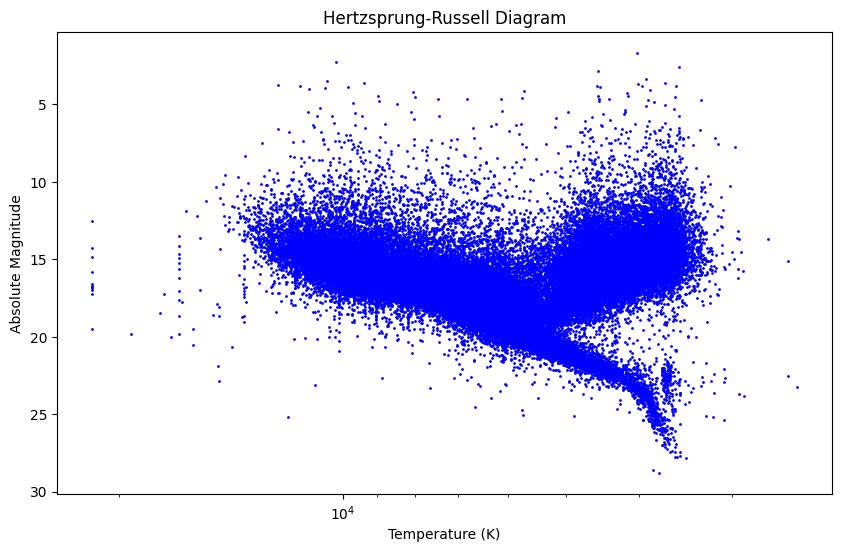

In [34]:
# Plotting the H-R Diagram
plt.figure(figsize=(10, 6))
plt.scatter(df2['Temperature'], df2['Amag'], c='blue', s=1)
plt.xscale('log')
plt.yscale('linear')
plt.gca().invert_xaxis()  # Temperature decreases to the right
plt.gca().invert_yaxis()  # Absolute magnitude increases downwards
plt.xlabel('Temperature (K)')
plt.ylabel('Absolute Magnitude')
plt.title('Hertzsprung-Russell Diagram')
plt.show()